In [29]:
import os
import sys
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('./')
sys.path.append('/home/li.yu/code/JupiterCVML/europa/base/src/europa')
from utils import normalize_image, plot_image, plot_images

In [2]:
# load human pose info
human_pose_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/all_human_pose.csv'
hp_df = pd.read_csv(human_pose_csv, converters={"properties__json": ast.literal_eval})
hp_df.drop('id', axis=1, inplace=True)
hp_df.rename({'image': 'id'}, axis=1, inplace=True)
print(hp_df.shape)
hp_df.head(2)

(122882, 2)


,id,properties__json
0,5f81f1d7bf0c3674c05778c4,"[{'featureId': 'cls9tzeqs000a356l9v59fjwt', 'v..."
1,60679aa31e3d26cab0c8c694,"[{'featureId': 'clsa1ufc10006356ns6mt2ud2', 'v..."


In [48]:
def get_human_pose(row):
    for label in row.properties__json:
        if label['title'] == 'Pose':
            row['Pose'] = label['answer']['title']
        if label['title'] == 'Human Clothing':
            row['Human Clothing'] = label['answer']['title']
    return row

def get_camera_pod(df, halo_data=True):
    if halo_data:
        from dl.utils.config_halo import HALO_CAMERAS_TO_PODS
        df['camera_pod'] = df['camera_location'].apply(lambda s: HALO_CAMERAS_TO_PODS[s])
    else:
        REV1_CAMERAS_TO_PODS = {'side-left-left': 'rear', 'side-right-left': 'rear', 'front-left-left': 'front',
                                'front-center-left': 'front', 'front-right-left': 'front', 'rear-left': 'rear',
                                'front-center-right': 'front', 'side-left-right': 'rear'}
        df['camera_pod'] = df['camera_location'].apply(lambda s: REV1_CAMERAS_TO_PODS[s])
    return df

def prepare_df(root_dir, dataset, csv, hp_df, dist_csv_path, halo_data=True):
    csv = os.path.join(root_dir, dataset, csv)
    converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
    df = pd.read_csv(csv, converters=converters)
    print('csv as loaded', df.shape)

    # drop duplicates on id
    df.drop_duplicates(subset='unique_id', inplace=True)
    df = get_camera_pod(df, halo_data)
    print('drop duplicated unique_id', df.shape)

    # load depth/distance info
    dist_df = pd.read_csv(dist_csv_path).drop_duplicates(subset='unique_id')
    final_df = df.merge(dist_df, on='unique_id')
    print('merge with dist df and get pod info', final_df.shape)

    # remove non-human images
    final_df = final_df[final_df['is_human_present'] == 'Yes']
    print('drop non-human image', final_df.shape)

    # merge human pose df
    final_df = final_df.merge(hp_df, on='id')
    print('merge with human pose info', final_df.shape)

    # retrieve human pose info
    final_df['Pose'] = ''
    final_df['Human Clothing'] = ''
    final_df = final_df.apply(lambda r: get_human_pose(r), axis=1)
    print('retrieve human pose info', final_df.shape)

    return final_df

In [4]:
# root_dir = '/data/jupiter/datasets/'
root_dir = '/data2/jupiter/datasets/'
# dataset = 'Jupiter_train_v6_2'
# dataset = 'humans_on_path_test_set_2023_v15_anno'
dataset = 'halo_rgb_stereo_train_v6_2'
# dataset = 'human_annotations_interim_halo_v6_2_2_mainline'
# csv = os.path.join(root_dir, dataset, 'annotations.csv')
csv = 'master_annotations_dedup.csv'
dist_csv_path = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_2_full_res.csv'

halo_train_hp_df = prepare_df(root_dir, dataset, csv, hp_df, dist_csv_path)

<ipython-input-4-408219246116>:11: DtypeWarning: Columns (2,3,24,26,82,93,94,95,96,97,99,100,102,103,104,105,106,107,108,109,110,120,151,153,157,158,163,172,175,178,181,182,184,188,190,200,201,203,204,205,206,211,228,233,234,235,236,238,240,241,242,253,254,256,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,277,282,283,284,287,288,289,291) have mixed types.Specify dtype option on import or set low_memory=False.
  halo_train_hp_df = prepare_df(root_dir, dataset, csv, hp_df, dist_csv_path)


csv as loaded (280564, 348)
drop duplicated unique_id (280564, 348)


<ipython-input-3-9b11c922c1ba>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['camera_pair'] = df['unique_id'].apply(lambda s: s[-7:])
<ipython-input-3-9b11c922c1ba>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['camera_pod'] = df['camera_pair'].apply(lambda s: camera_pairs_to_pods[s])


merge with dist df and get pod info (279612, 369)
drop non-human image (46109, 369)
merge with human pose info (45601, 370)


<ipython-input-3-9b11c922c1ba>:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df['Pose'] = ''
<ipython-input-3-9b11c922c1ba>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df['Human Clothing'] = ''


retrieve human pose info (45601, 372)


In [49]:
# # Halo test
# root_dir = '/data2/jupiter/datasets/'
# dataset2 = 'human_annotations_interim_halo_v6_2_mainline'
# csv2 = 'master_annotations.csv'
# dist_csv_path2 = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/test_v6_2.csv'

# Rev1 train
root_dir = '/data2/jupiter/datasets/'
dataset2 = 'Jupiter_train_v6_2'
csv2 = 'master_annotations.csv'
dist_csv_path2 = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/rev1_train_v6_2.csv'

halo_test_hp_df = prepare_df(root_dir, dataset2, csv2, hp_df, dist_csv_path2, halo_data=False)

<ipython-input-49-884abde6f4da>:13: DtypeWarning: Columns (6,7,39,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,75,76,77,78,80,81,82,83,84,85,86,87,88,89,90,109,110,111,112,114,115,116,117,118,119,120,121,122,123,124,143,144,145,146,148,149,150,151,152,153,154,155,156,157,158,160,161,162,163,165,166,167,168,169,170,171,172,173,174,175,177,178,179,180,182,183,184,185,186,187,188,189,190,191,192,223,225,227,230,247,251,254,255,261,262,263,267,308,319,324,327,337,338,346,354,370,371,373,374,376,377) have mixed types.Specify dtype option on import or set low_memory=False.
  halo_test_hp_df = prepare_df(root_dir, dataset2, csv2, hp_df, dist_csv_path2, halo_data=False)


csv as loaded (321638, 424)
drop duplicated unique_id (321638, 425)
merge with dist df and get pod info (321638, 444)
drop non-human image (58140, 444)
merge with human pose info (49510, 445)


<ipython-input-48-09b1a411065f>:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df['Pose'] = ''
<ipython-input-48-09b1a411065f>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df['Human Clothing'] = ''


retrieve human pose info (49510, 447)


In [50]:
all_pose = list(set(halo_train_hp_df.Pose.unique()) | set(halo_test_hp_df.Pose.unique()))
all_clothing = list(set(halo_train_hp_df['Human Clothing'].unique()) | set(halo_test_hp_df['Human Clothing'].unique()))
all_pose.sort()
all_clothing.sort()
print(all_pose, all_clothing)

['bent_over', 'carrying_object', 'crouching_kneeling_sitting_squatting', 'greeting_embrace', 'holding_child', 'leaning', 'lifting_object', 'lying_down', 'pointing', 'pushing_object', 'reading_phone_book_object', 'running_walking', 'standing_hands_down'] ['', 'bright_clothing', 'camo_clothing', 'dark_clothing', 'mixed_clothing']


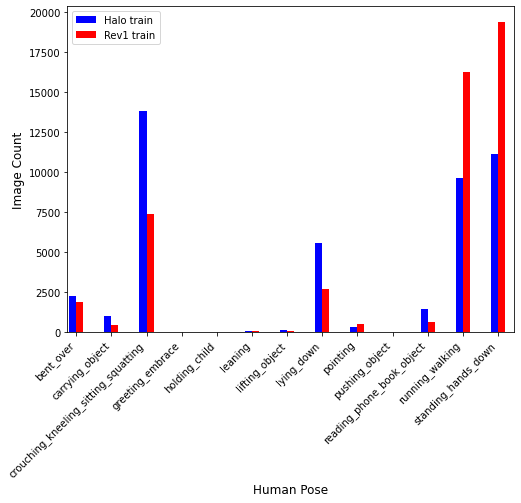

In [51]:
halo_train_g = halo_train_hp_df[['id', 'Pose']].groupby('Pose').count()
halo_train_g.rename(columns={"id": "Halo train"}, inplace=True)
halo_test_g = halo_test_hp_df[['id', 'Pose']].groupby('Pose').count()
# halo_test_g.rename(columns={"id": "Halo test"}, inplace=True)
halo_test_g.rename(columns={"id": "Rev1 train"}, inplace=True)

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
halo_train_g.plot.bar(rot=0, color='blue', ax=ax, position=1.0, width=0.2, sharex=True, sharey=True)
halo_test_g.plot.bar(rot=0, color='red', ax=ax, position=0.0, width=0.2, sharex=True, sharey=True)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Human Pose", fontsize=12)
plt.ylabel("Image Count", fontsize=12)
plt.show()

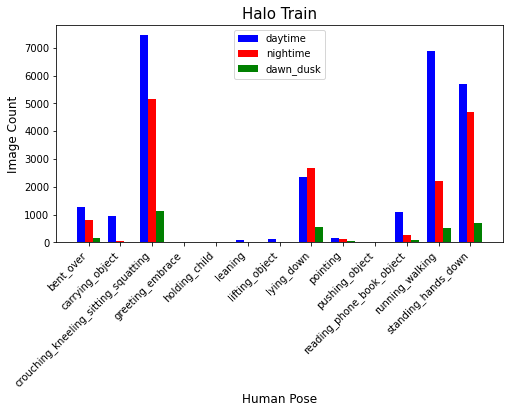

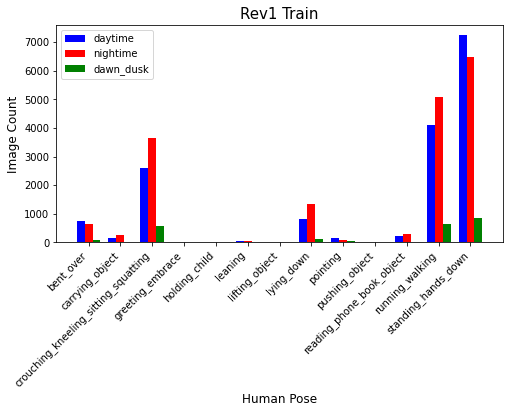

In [52]:
# human pose per operation time
def human_pose_dist_vs_op_time(halo_train_hp_df, title):
    halo_train_g = halo_train_hp_df[['id', 'Pose', 'operation_time']].groupby(['operation_time', 'Pose']).size().reset_index(name='counts')

    N = len(all_pose)
    ind = np.arange(N)
    width = 0.25

    fig = plt.figure(1, figsize=(8, 4))
    op_times = ['daytime', 'nightime', 'dawn_dusk']
    bars, colors = [], ['b', 'r', 'g']
    for i, (op_time, c) in enumerate(zip(op_times, colors)):
        sub_df = halo_train_g[halo_train_g.operation_time == op_time]
        counts_d = dict(zip(sub_df['Pose'], sub_df['counts']))
        counts = [counts_d.get(p, 0) for p in all_pose]
        bar = plt.bar(ind+width*i, counts, width, color=c)
        bars.append(bar)
    plt.xlabel('Human Pose', fontsize=12)
    plt.ylabel('Image Count', fontsize=12)
    plt.title(title, fontsize=15)
    plt.xticks(ind+width, all_pose, rotation=45, ha='right')
    plt.legend(bars, op_times)
    plt.show()

human_pose_dist_vs_op_time(halo_train_hp_df, "Halo Train")
# human_pose_dist_vs_op_time(halo_test_hp_df, "Halo Test")
human_pose_dist_vs_op_time(halo_test_hp_df, "Rev1 Train")

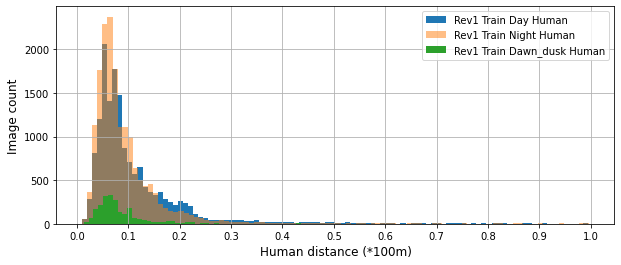

In [82]:
# human pose per distance

# # general
# plt.figure(1, figsize=(10, 6))
# halo_train_hp_df[(halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# halo_test_hp_df[(halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100, alpha=0.5)
# # plt.legend(['Halo Train', 'Halo Test'])
# plt.legend(['Halo Train', 'Rev1 Train'])

# # lying down vs. standing
# plt.figure(1, figsize=(10, 4))
# # halo_train_hp_df[(halo_train_hp_df['Pose'].isin(['running_walking', 'standing_hands_down'])) & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# # halo_train_hp_df[(halo_train_hp_df['Pose'].isin(['lying_down'])) & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# # plt.legend(['Halo Train Standing Human', 'Halo Train Lying Down Human'])
# halo_test_hp_df[(halo_test_hp_df['Pose'].isin(['running_walking', 'standing_hands_down'])) & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# halo_test_hp_df[(halo_test_hp_df['Pose'].isin(['lying_down'])) & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# # plt.legend(['Halo Test Standing Human', 'Halo Test Lying Down Human'])
# plt.legend(['Rev1 Train Standing Human', 'Rev1 Train Lying Down Human'])

# day vs night
plt.figure(1, figsize=(10, 4))
# halo_train_hp_df[(halo_train_hp_df['operation_time'] == 'daytime') & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# halo_train_hp_df[(halo_train_hp_df['operation_time'] == 'nightime') & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# halo_train_hp_df[(halo_train_hp_df['operation_time'] == 'dawn_dusk') & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# plt.legend(['Halo Train Day Human', 'Halo Train Night Human', 'Halo Train Dawn_dusk Human'])
halo_test_hp_df[(halo_test_hp_df['operation_time'] == 'daytime') & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
halo_test_hp_df[(halo_test_hp_df['operation_time'] == 'nightime') & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100, alpha=0.5)
halo_test_hp_df[(halo_test_hp_df['operation_time'] == 'dawn_dusk') & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# plt.legend(['Halo Test Day Human', 'Halo Test Night Human', 'Halo Test Dawn_dusk Human'])
plt.legend(['Rev1 Train Day Human', 'Rev1 Train Night Human', 'Rev1 Train Dawn_dusk Human'])

plt.xticks([i/10 for i in range(0, 11)])
plt.xlabel('Human distance (*100m)', fontsize=12)
plt.ylabel('Image count', fontsize=12)
plt.show()

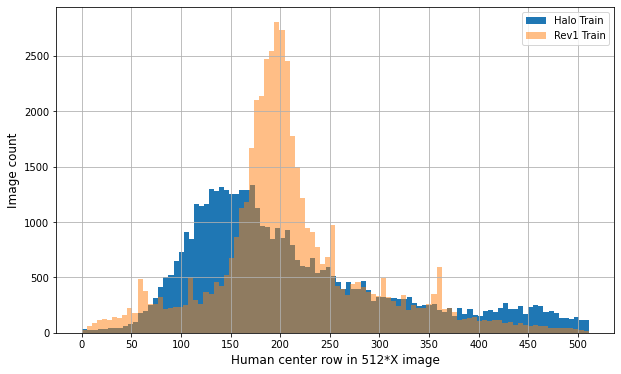

In [62]:
# human location on image
halo_train_hp_df['human_mid_row'] = halo_train_hp_df.apply(lambda r: (r['human_min_row'] + r['human_max_row']) / 4, axis=1)
halo_test_hp_df['human_mid_row'] = halo_test_hp_df.apply(lambda r: (r['human_min_row'] + r['human_max_row']) / 2, axis=1)
plt.figure(1, figsize=(10, 6))
halo_train_hp_df['human_mid_row'].hist(bins=100)
halo_test_hp_df['human_mid_row'].hist(bins=100, alpha=0.5)
plt.legend(['Halo Train', 'Rev1 Train'])
plt.xticks([i for i in range(0, 512, 50)])
plt.xlabel('Human center row in 512*X image', fontsize=12)
plt.ylabel('Image count', fontsize=12)
plt.show()
plt.show()

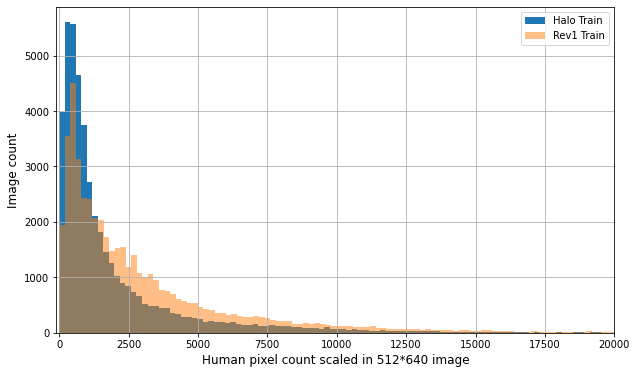

In [83]:
# human pixel counts on image
def scale_pixels(row):
    s = row.image_size
    h, w = s[1:-1].split(', ')
    h, w = int(h), int(w)
    row['human_pixels_scaled'] = row['human_pixels'] / (h * w) * (512 * 640)
    return row

# halo_train_hp_df = halo_train_hp_df.apply(lambda r: scale_pixels(r), axis=1)
# halo_test_hp_df = halo_test_hp_df.apply(lambda r: scale_pixels(r), axis=1)

plt.figure(1, figsize=(10, 6))
pixel_limit = 20000
halo_train_hp_df[halo_train_hp_df['human_pixels_scaled'] < pixel_limit]['human_pixels_scaled'].hist(bins=100)
halo_test_hp_df[halo_test_hp_df['human_pixels_scaled'] < pixel_limit]['human_pixels_scaled'].hist(bins=100, alpha=0.5)
plt.legend(['Halo Train', 'Rev1 Train'])
# plt.xticks([i for i in range(0, 512, 50)])
plt.xlim(-100, pixel_limit)
plt.xlabel('Human pixel count scaled in 512*640 image', fontsize=12)
plt.ylabel('Image count', fontsize=12)
plt.show()
plt.show()

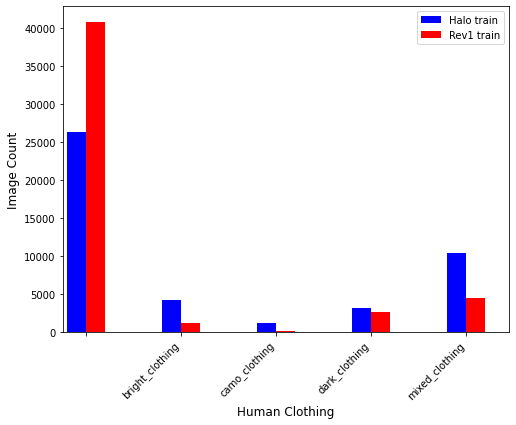

In [77]:
halo_train_g = halo_train_hp_df[['id', 'Human Clothing']].groupby('Human Clothing').count()
halo_train_g.rename(columns={"id": "Halo train"}, inplace=True)
halo_test_g = halo_test_hp_df[['id', 'Human Clothing']].groupby('Human Clothing').count()
# halo_test_g.rename(columns={"id": "Halo test"}, inplace=True)
halo_test_g.rename(columns={"id": "Rev1 train"}, inplace=True)

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
halo_train_g.plot.bar(rot=0, color='blue', ax=ax, position=1.0, width=0.2, sharex=True, sharey=True)
halo_test_g.plot.bar(rot=0, color='red', ax=ax, position=0.0, width=0.2, sharex=True, sharey=True)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Human Clothing", fontsize=12)
plt.ylabel("Image Count", fontsize=12)
plt.show()

## Show example images

In [72]:
# sub_df = df[df.id == df.sample(1).iloc[0].id]
# print(sub_df.shape)

sub_df = halo_train_hp_df[halo_train_hp_df['Human Clothing'] == '']
print(sub_df.shape)

(22340, 351)


6559f1808907080903feb801 6559f1808907080903feb801_T14_T16 T14


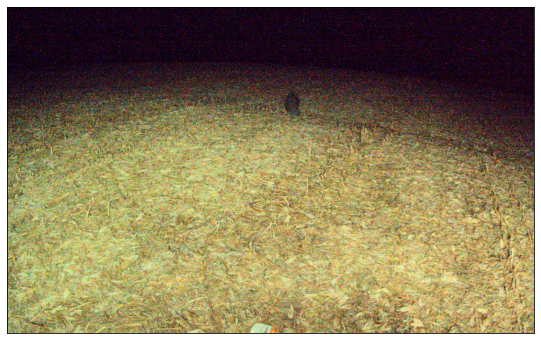

6546870009ac9db3e23ca6ca 6546870009ac9db3e23ca6ca_T14_T16 T14


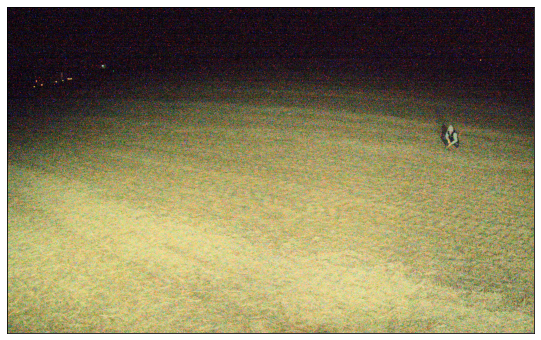

In [73]:
# sub_df = df2[df2.camera_pod == 'implement_pod'].sample(5)
# sub_df = df[(~df.unique_id.isin(negative_ids)) & (df.unique_id.isin(negative_ids_depth30))].sample(2)
# sub_df = df[df.id.isin(cat_df.id)].sample(2)
# sub_df = df[df.bag_date == '12_04_2023'].sample(2)
# sub_df = df[df.unique_id.isin(['64f24c35185004ffd6db442a_T13_T15', '64f103a37f23cbe32a523272_I02_I04'])]
# sub_df = df2.sample(5)
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
show_image, show_label = False, False
show_debayered_rgb, show_raw_label = True, False

for i, row in sub_df.sample(2).iterrows():
    print(row.id, row.unique_id, row.camera_location)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label == 25)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label == 25)